In [9]:
from datamodules import SHMUDataModule
from pathlib import Path
from utils.config import load_config

confpath = Path("") / "configs/LUPIN_differenced"
dsconf = load_config(confpath / "datasets.yaml")
modelconf = load_config(confpath / "model.yaml")

datamodule = SHMUDataModule(dsconf, modelconf.train_params)
datamodule.setup("test")
dataset = datamodule.test_dataset

test_dataloader = datamodule.test_dataloader()

In [10]:
import torch
from models import LUMIN

model = LUMIN(modelconf).load_from_checkpoint("/data/softec-lagrangian-nowcasting/checkpoints/LUMIN-differenced-pretrainedMFUNET-rmse/epoch=4-step=1280.ckpt", config=modelconf, map_location=torch.device('cuda:0'))

In [2]:
import torch
from models import MFUNET

model = MFUNET(modelconf).load_from_checkpoint("/data/softec-lagrangian-nowcasting/checkpoints/mfunet-logcosh/epoch=19-step=2960.ckpt", config=modelconf, map_location=torch.device('cpu'))

In [22]:
x = dataset[40][0]
x = torch.unsqueeze(torch.squeeze(x), dim=0).float().to('cuda:0')
# x = torch.log(x + 0.01)
# x[x < 0] = x.min()

y = dataset[40][1]
y = torch.unsqueeze(torch.squeeze(y), dim=0).float().to('cuda:0')

In [23]:
extra, mf = model(x)

y_i = torch.diff(torch.cat((extra, y[:, None, 0, :, :]), dim=1), dim=1)

pred_np = extra.detach().cpu().numpy()
# mf = mf[0].detach().cpu().numpy()

nowcast, mfcast = model._iterative_prediction((x, y, None), stage='predict')
nowcast_np = dataset.from_transformed(nowcast).detach().cpu().numpy()
mfcast_np = mfcast.detach().cpu().numpy()

pred_total_np = dataset.from_transformed((extra).detach().cpu()).numpy()

ValueError: too many values to unpack (expected 2)

In [24]:
pred, extra, mf = model(x)

y_i = torch.diff(torch.cat((pred, y[:, None, 0, :, :]), dim=1), dim=1)

pred_np = pred.detach().cpu().numpy()
# mf = mf[0].detach().cpu().numpy()
nowcast = model._iterative_prediction((x, y, None), stage='predict')
nowcast, mfcast = model._iterative_prediction((x, y, None), stage='predict')

In [25]:
import numpy as np

nowcast_np = dataset.from_transformed(nowcast).detach().cpu().numpy()
nowcast_np_mmh = nowcast.detach().cpu().numpy()
nowcast_np_mmh[nowcast_np_mmh <= 1] = 0
mfcast_np = mfcast.detach().cpu().numpy()
pred_total_np = dataset.from_transformed((pred + extra).detach().cpu()).numpy()

x_lagrangian = x.clone()

for i in range(x.shape[1]):
    x_lagrangian[:,i] = model._extrapolate(6-i, x_lagrangian[:,[i]], (mf))[:,-1]

x_lagrangian_diff = torch.diff(x_lagrangian, dim=1)
x_np = np.array(dataset.from_transformed(x[0].detach().cpu()))
x_np_mmh = np.array(x[0].detach().cpu())
x_np_mmh[x_np_mmh <= 1] = 0
y_np = np.array(dataset.from_transformed(y[0].detach().cpu()))
x_lagrangian_np = np.array(dataset.from_transformed(x_lagrangian[0].detach().cpu()))
x_lagrangian_diff_np = np.array(x_lagrangian_diff[0].detach().cpu())
y_i_np = y_i.detach().cpu().numpy()

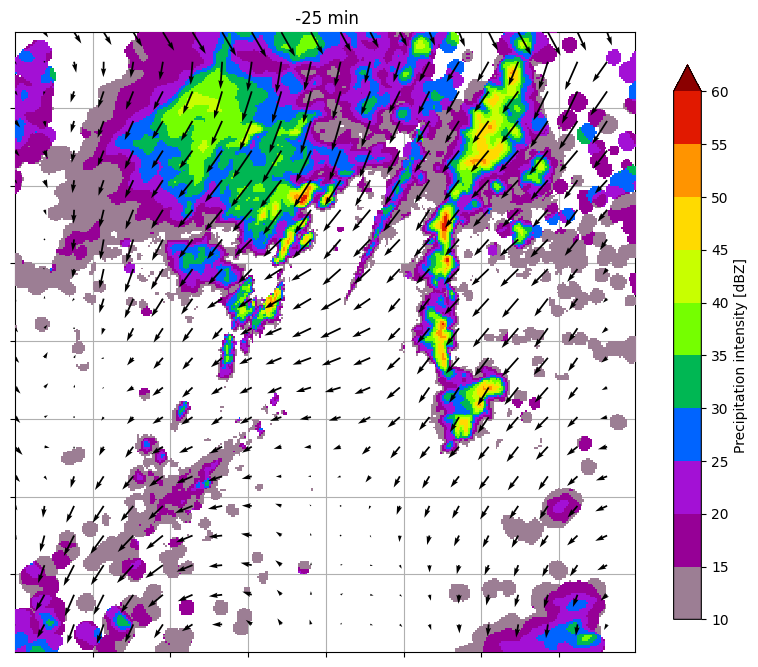

In [26]:
import matplotlib.pyplot as plt
import matplotlib.animation as animate
from IPython.display import HTML
from pysteps.visualization import plot_precip_field, quiver

fig, ax = plt.subplots(figsize=(10, 9))

plot_precip_field(x_lagrangian_np[0], units='dBZ')

def update(frame):
    plt.cla()
    if frame >= 6:
        #plt.imshow(nowcast_np[0][frame-6], vmin=0, vmax=70, cmap='gist_ncar')
        plot_precip_field(nowcast_np[0][frame-6], colorbar=False, units='dBZ')
        quiver(mfcast_np[0][frame-6], step=16, quiver_kwargs={'scale': 100})
        # plt.title(f"{(frame-5)*5:+4d} min")
    else:
        #plt.imshow(x_np[frame], vmin=0, vmax=70, cmap='gist_ncar')
        plot_precip_field(x_np[frame], colorbar=False, units='dBZ')
        quiver(mfcast_np[0][0], step=16, quiver_kwargs={'scale': 100})
        # plt.title(f"{(frame-5)*5:+4d} min")
    ax.xaxis.set_ticks(np.array([1, 2, 3, 4, 5, 6, 7]) * 42)
    ax.yaxis.set_ticks(np.array([1, 2, 3, 4, 5, 6, 7]) * 42)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.grid(True)
    plt.title(f"{(frame-5)*5:+4d} min")

ani = animate.FuncAnimation(fig=fig, func=update, frames=12)
HTML(ani.to_jshtml())

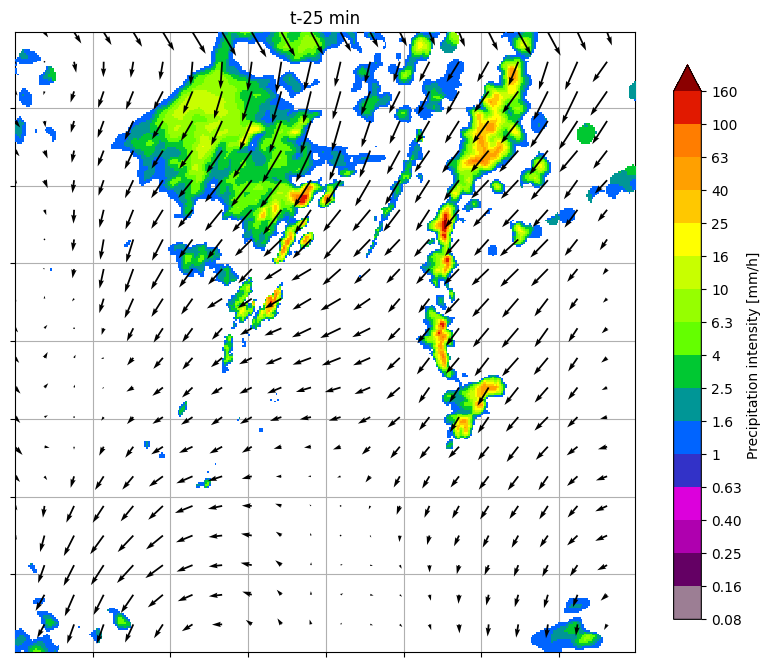

In [29]:
import matplotlib.pyplot as plt
import matplotlib.animation as animate
from IPython.display import HTML
from pysteps.visualization import plot_precip_field, quiver

fig, ax = plt.subplots(figsize=(10, 9))

plot_precip_field(x_np_mmh[0])

def update(frame):
    plt.cla()
    if frame >= 6:
        #plt.imshow(nowcast_np[0][frame-6], vmin=0, vmax=70, cmap='gist_ncar')
        plot_precip_field(nowcast_np_mmh[0][frame-6], colorbar=False)
        quiver(mfcast_np[0][frame-6], step=16, quiver_kwargs={'scale': 100})
        # plt.title(f"{(frame-5)*5:+4d} min")
    else:
        #plt.imshow(x_np[frame], vmin=0, vmax=70, cmap='gist_ncar')
        plot_precip_field(x_np_mmh[frame], colorbar=False)
        quiver(mfcast_np[0][0], step=16, quiver_kwargs={'scale': 100})
        # plt.title(f"{(frame-5)*5:+4d} min")
    ax.xaxis.set_ticks(np.array([1, 2, 3, 4, 5, 6, 7]) * 42)
    ax.yaxis.set_ticks(np.array([1, 2, 3, 4, 5, 6, 7]) * 42)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.grid(True)
    plt.title(f"t{(frame-5)*5:+2d} min")

ani = animate.FuncAnimation(fig=fig, func=update, frames=12)
HTML(ani.to_jshtml())

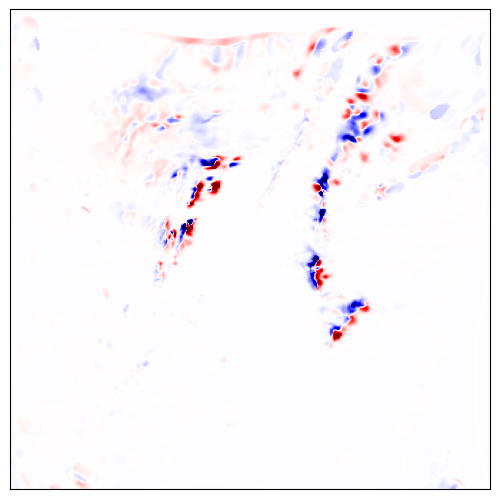

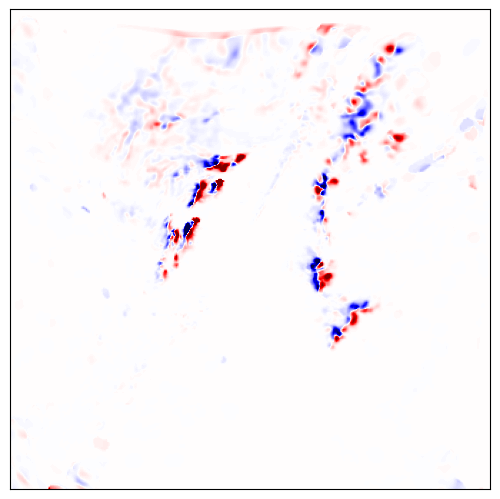

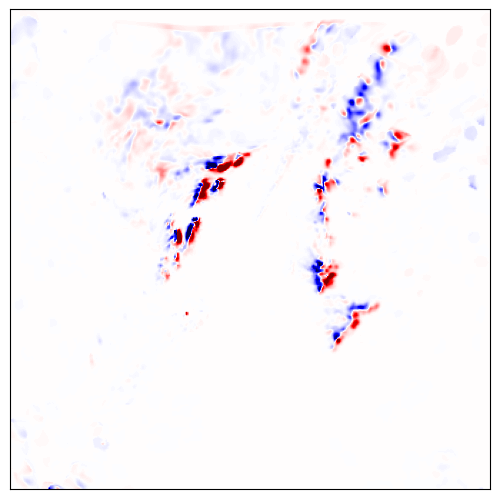

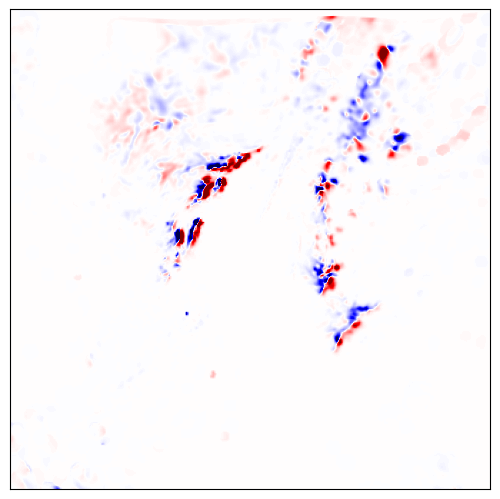

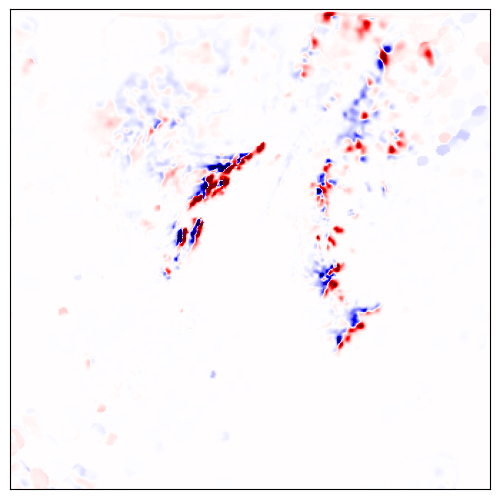

In [51]:
for i in range(5):
    fig = plt.figure()
    
    ax = plt.gca()
    # plt.axis('off')
    plt.imshow(x_lagrangian_diff_np[i], cmap='seismic', vmin=-30, vmax=+30)
    plt.rcParams['xtick.bottom'] = False
    plt.rcParams['xtick.labelbottom'] = False
    plt.rcParams['ytick.left'] = False
    plt.rcParams['ytick.labelleft'] = False
    fig.patch.set_alpha(0)
    
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.show()

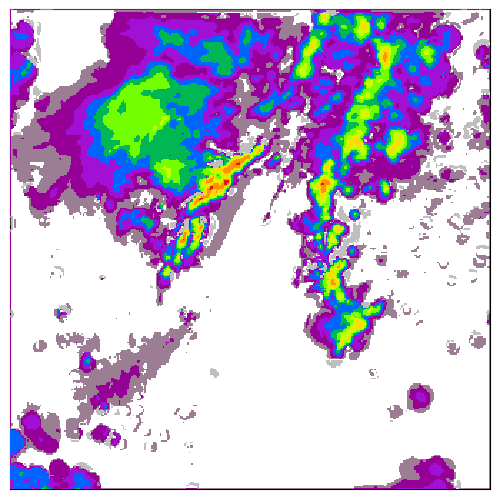

In [62]:
fig = plt.figure()
    
ax = plt.gca()
# plt.axis('off')
plot_precip_field(pred_total_np[0][0], units='dBZ', colorbar=False)
fig.patch.set_alpha(0)

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()

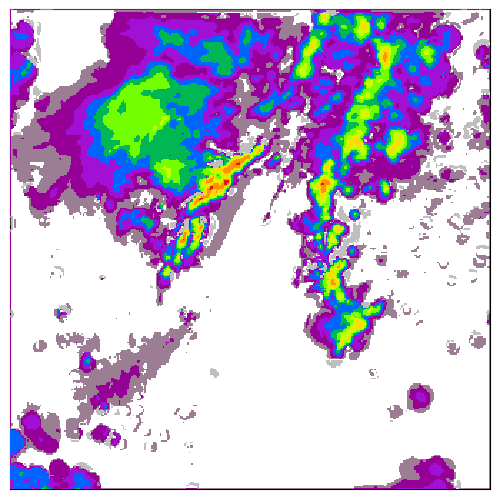

In [ ]:
fig = plt.figure()
    
ax = plt.gca()
# plt.axis('off')
plot_precip_field(pred_total_np[0][0], units='dBZ', colorbar=False)
fig.patch.set_alpha(0)

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()

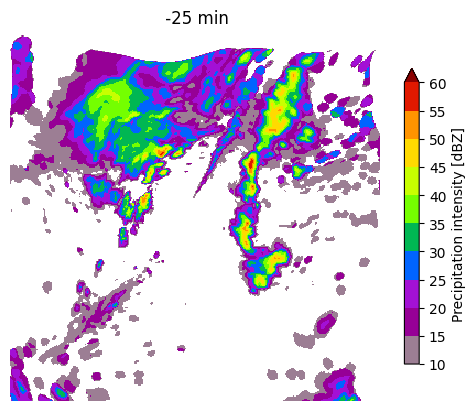

In [31]:
import matplotlib.pyplot as plt
import matplotlib.animation as animate
from IPython.display import HTML
from pysteps.visualization import plot_precip_field

fig, ax = plt.subplots()

plot_precip_field(x_lagrangian_np[0], units='dBZ')

def update(frame):
    plt.cla()
    if frame >= 6:
        plot_precip_field(nowcast_np[0][frame-6], colorbar=False, units='dBZ')
        # plt.title(f"{(frame-5)*5:+4d} min")
    else:
        plot_precip_field(x_lagrangian_np[frame], colorbar=False, units='dBZ')
        # plt.title(f"{(frame-5)*5:+4d} min")
    plt.axis('off')
    plt.title(f"{(frame-5)*5:+4d} min")

ani = animate.FuncAnimation(fig=fig, func=update, frames=12)
HTML(ani.to_jshtml()) 

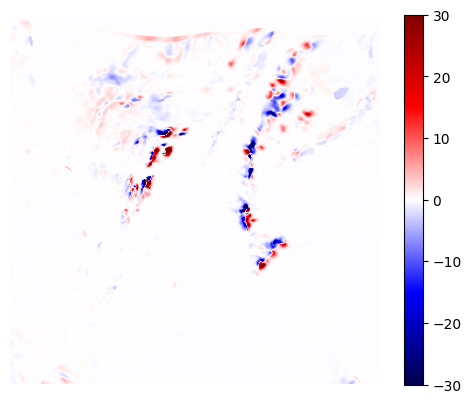

In [52]:
import matplotlib.pyplot as plt
import matplotlib.animation as animate
from IPython.display import HTML

fig, ax = plt.subplots()

plt.imshow(pred_np[0][0], cmap='seismic', vmin=-30, vmax=30)
cbar = plt.colorbar()

# x_lagrangian_diff_np[x_lagrangian_diff_np == 0] = np.nan
# y_i_np[y_i_np <= 0] = np.nan

def update(frame):
    plt.cla()
    if frame == 5:
        plt.imshow(pred_np[0][0], cmap='seismic', vmin=cbar.vmin, vmax=cbar.vmax)
    else:
        plt.imshow(x_lagrangian_diff_np[frame], cmap='seismic', vmin=cbar.vmin, vmax=cbar.vmax)
    plt.axis('off')
    # plt.title(f"{(frame-5)*5:+4d} min")
    # plt.show()

ani = animate.FuncAnimation(fig=fig, func=update, frames=6)
HTML(ani.to_jshtml())

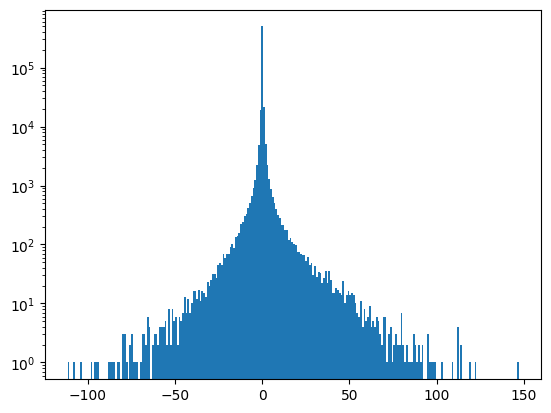

In [23]:
plt.hist(x_lagrangian_diff_np.flatten(), bins=256)
plt.yscale('log')

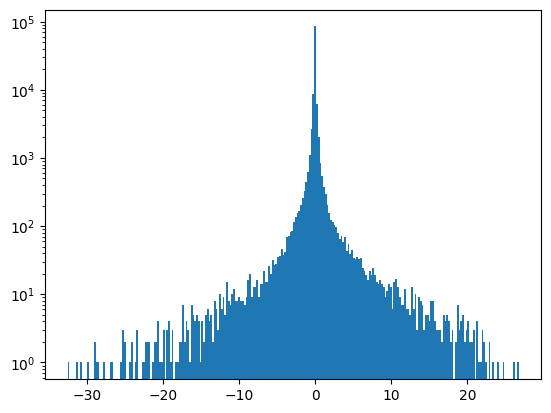

In [24]:
plt.hist(pred_np.flatten(), bins=256)
plt.yscale('log')

<Axes: >

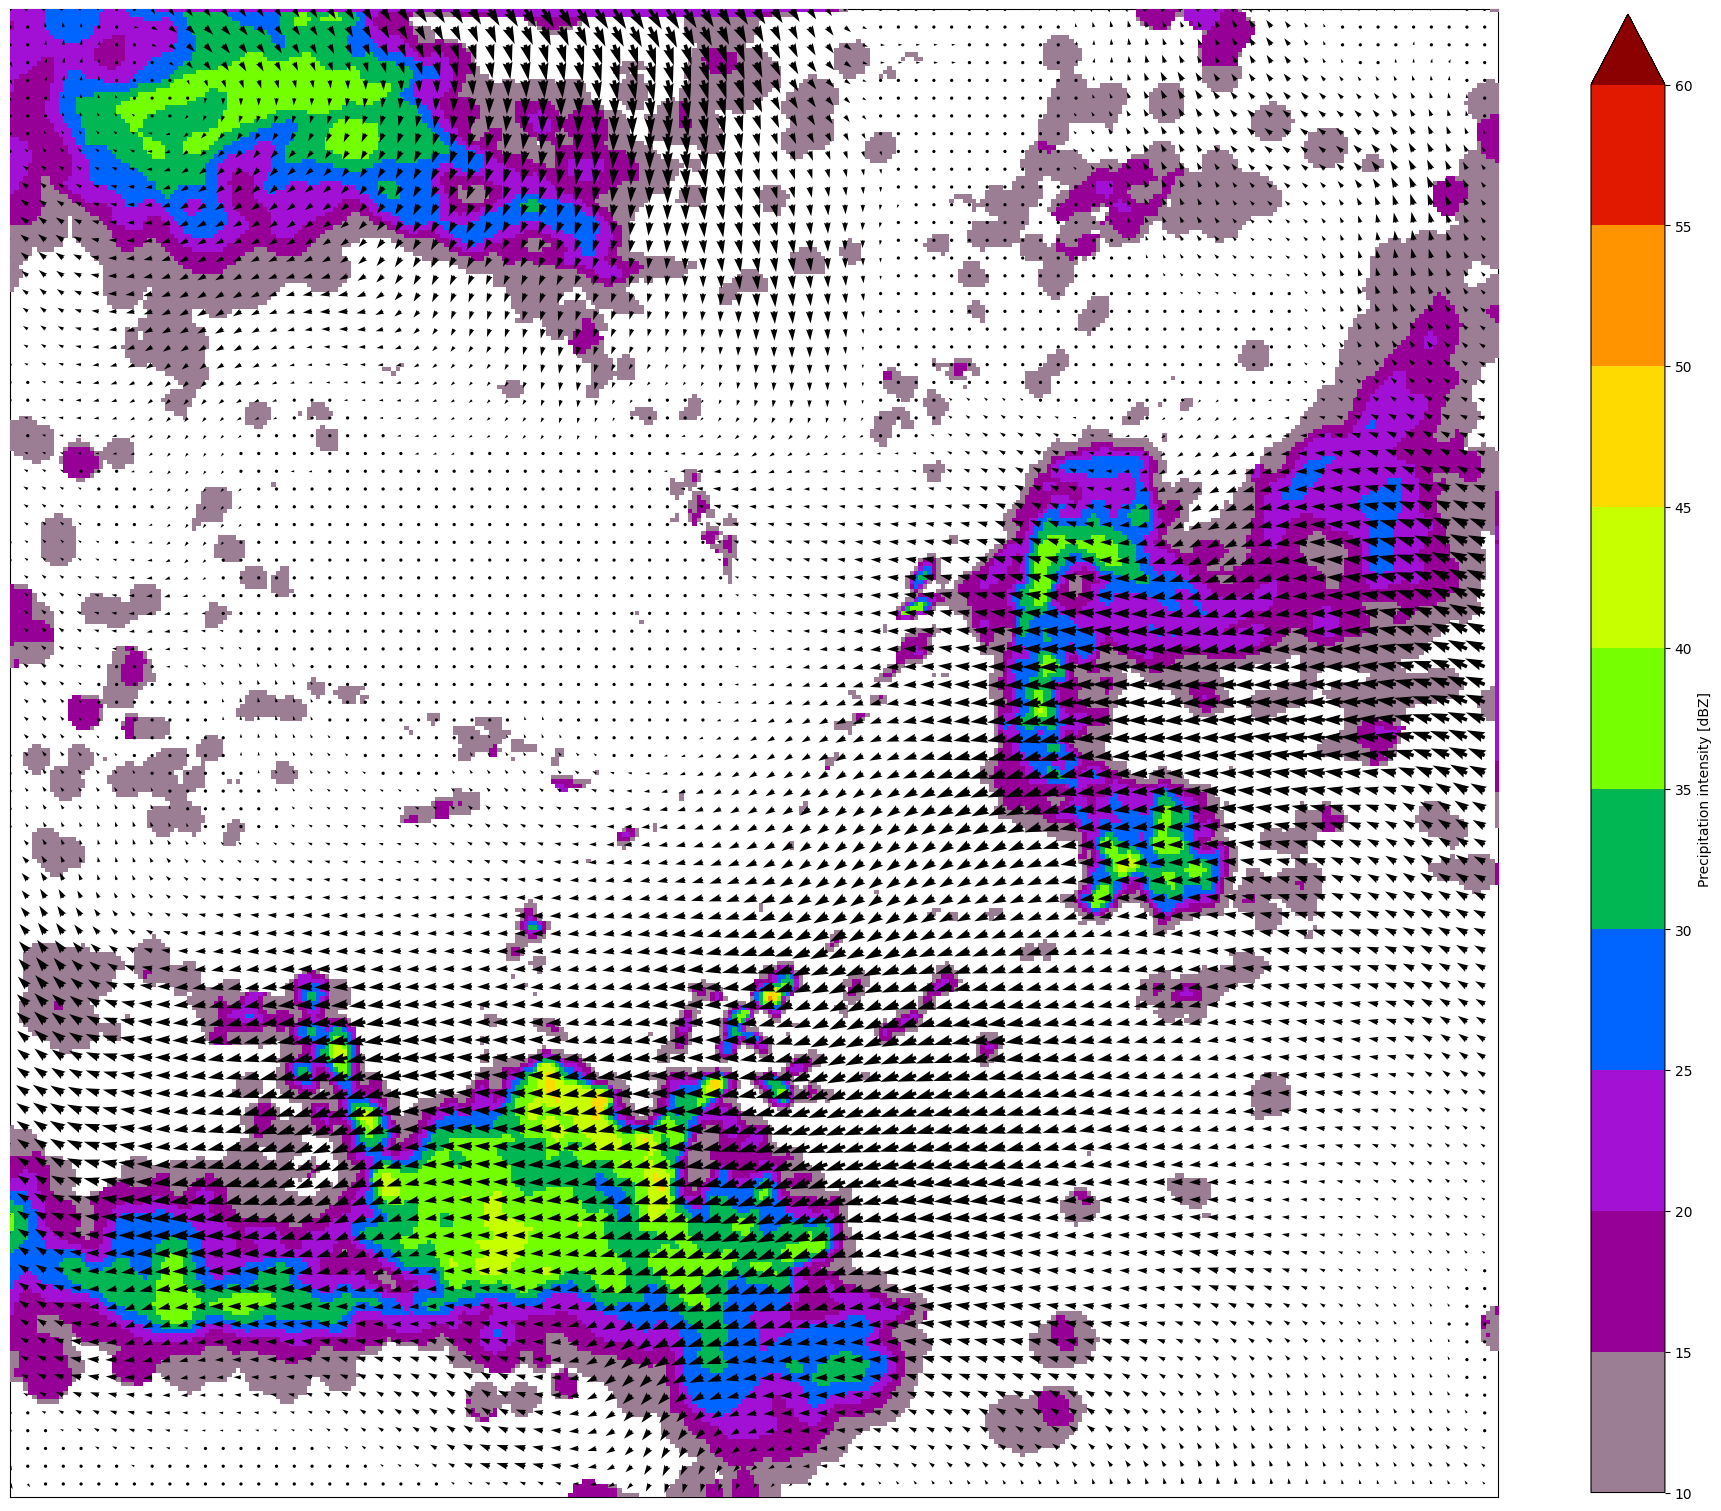

In [20]:
from pysteps.visualization import plot_precip_field, quiver
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

fig, ax = plt.subplots(figsize=(24, 24))
# plt.imshow(x_np[-1], cmap='gist_ncar')
plot_precip_field(pred_total_np[0][0], ax=ax, axis="off", units="dBZ")
mf_np = mf[0].detach().cpu().numpy()
#mf_np[mf_np > 0.1] = 0.1
#mf_np[mf_np < -0.1] = -0.1
# mf_np[1] *= -1

# Plot the motion field vectors
quiver(mf_np, step=4)